### Brief description of the planned analysis

**Data sanity checks**

- compute the duration of the main session of the experiment per person
- plot duration over time (lineplot)
- check the number of trails each participant completed/condition -> which are missing?
- check the performance by condition
- screen size parameters -> plot
- screen timing -> mean refresh rates
- calibration parameters -> pix/degree, distance from phone ...

**Demographic Data**
- age distribution
- gender
- location in the world (map?)

**Data preprocessing**
- mean center x and y coordinates
    - individually for each of the 6 locations
- check outliers -> how many are there for each participant, color-code them
- convert position in pixel to position in dva (expressed relative to screen center)

**Data Analysis Dip**
- individually compute movement rate
    - compute the trial number!
    - normalize to baseline, 100 ms before onset after doing the right trial correction
- from normalized baseline, compute:
    - minimum movement frequency
    - bottom of the dip - (baseline - min) + 0.1 * (baseline - min)
    - latency to maximum movement inhibition
    - magnitude of the inhibition
    - latency to 50% maximum inhibition
    - duration of the inhibition
- check deviation from baseline: baseline = no flash, no shift
- ANOVA: magnitude of the inhibition ~ (flash_condition x shift_condition)/subject
- ANOVA: duration of the inhibition ~ (flash_condition x shift_condition)/subject
- latency: MEASURE OF CLUTTERING?

**Data Analysis Error**
- compute the distance touch response -> corresponding dot (for shifted and non-shifted arrays)
- compute average error from non-shift trials
- compute -> does the order of the dots explain the error?
- linear model (y = a * x + b) 
- mean model of the data (y = b)
- subtract the error predicted by the model from the actual error.
- compute moving-window average error
- fit logistic regression:
        L/(1+e^(k(x-x0)))
        
        where L is the maximum error value, k the decay rate (steepness of the function) and x0 is the midpoint of the function (shift)

- parameters L, k, x0 -> ANOVA

**Quantify Improvement of Performance through inhibition**
- Given logistic regression -> estimated from participant
- What's the optimal duration, magnitude and latency for inhibition?
- response-generating function? 
- constraint by timing requirements
- Are the optimal values correlated with the actual values?

### Imports 

In [1]:
import helper_funcs as helper
import json
import loading_data as loader
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from preprocessing import preprocessing_pipeline

### Paths 

In [2]:
data_path            = '../data/study_data_multiple_sessions/'
jatos_rawfile_path   = data_path + 'full_datafile.txt' 
data_file            = data_path + 'full_datafile.csv'
metadata_path        = data_path + 'metadata_prolific/'
incomplete_main_path = data_path + 'incomplete_main_sessions/'
jatos_extrafile_path = data_path + 'additional_datafile.txt'
jatos_extraquestion_path = data_path + 'missing_questionnaire.csv'

calibration_path = data_path + 'all_calibrations.csv'
calibration_params_path = data_path + 'all_calibration_params.csv'
training_path = data_path + 'all_trainings.csv'
questions_path = data_path + 'all_questions.csv'
trial_path = data_path + 'all_trials.csv'
successful_trials_path = data_path + 'all_successful_trials.pkl'
successful_trials_long_path = data_path + 'all_successful_trials_long.csv'


path_names = {'source': jatos_rawfile_path,
             'incomplete': incomplete_main_path,
             'extra': jatos_extrafile_path,
             'extra_questions': jatos_extraquestion_path,
             'out_file': data_file}

### Loading data

In [3]:
data = loader.load_all_data(path_names)

### Preprocessing data

In [4]:
calibration_data, training_data, main_session_data, trial_data, question_data, calibration_params, trial_data_long_format = preprocessing_pipeline(data_file)

calibration_data.to_csv(calibration_path, index = False)
calibration_params.to_csv(calibration_params_path, index = False)
training_data.to_csv(training_path, index = False)
question_data.to_csv(questions_path, index = False)
trial_data.to_csv(trial_path, index = False)

trial_data_successful=trial_data[trial_data.success == 1]
trial_data_successful.reset_index(inplace=True, drop=True)

In [5]:
data.columns

Index(['success', 'timeout', 'failed_images', 'failed_audio', 'failed_video',
       'trial_type', 'trial_index', 'time_elapsed', 'internal_node_id',
       'subject', 'prolific_id', 'study_id', 'session_id', 'session_number',
       'component', 'rt', 'response', 'question_order', 'test_part',
       'item_width_mm', 'item_height_mm', 'item_width_px', 'px2mm',
       'view_dist_mm', 'item_width_deg', 'px2deg', 'win_width_deg',
       'win_height_deg', 'stimulus', 'button_pressed', 'trialShown',
       'startTime', 'endTime', 'flashOnTime', 'flashOffTime', 'touchOn',
       'touchOff', 'scheduled_change_onset', 'flash_duration', 'change_onset',
       'trial_duration', 'animation_timestamps', 'touchX', 'touchY',
       'choiceOrder', 'position_x', 'position_y', 'shifted_position_x',
       'shifted_position_y', 'lateResponse', 'orderResponse', 'tooManyTouches',
       'screenInLandscape', 'windowWidth', 'windowHeight', 'userInfo',
       'platform', 'flashTime', 'trialID', 'stimJumped'

### Duration of the main session

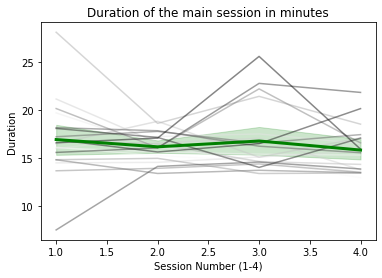

In [6]:
time_data = trial_data.groupby(['prolific_id', 'session_number']).describe()['time_elapsed']

elapsed_time = (time_data['max'] - time_data['min'])/60000
elapsed_time = elapsed_time.reset_index()

# plotting
duration_fig, duration_axs = plt.subplots(1,1)
sns.lineplot(data=elapsed_time, x="session_number", y=0, 
             hue="prolific_id", palette='Greys', alpha = 0.5, 
             legend = False, ax = duration_axs)

sns.lineplot(data=elapsed_time, x="session_number", y=0, 
             color='Green', linewidth = 3, legend = False, ax = duration_axs)

duration_axs.set_title('Duration of the main session in minutes')
duration_axs.set_xlabel('Session Number (1-4)')
duration_axs.set_ylabel('Duration');

### Missing data points

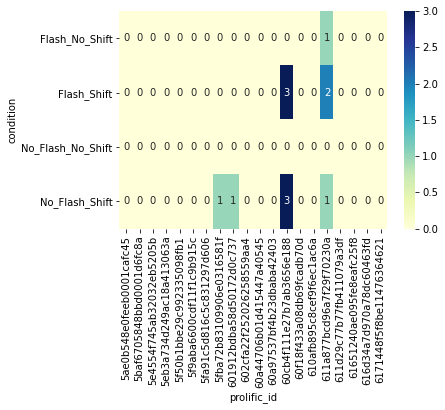

In [7]:
trial_count_data = trial_data_successful.groupby(['prolific_id', 'condition']).describe()['success']
trial_count = 200 - trial_count_data['count']
trial_count = trial_count.reset_index()
trial_count = trial_count.pivot("condition", "prolific_id", "count")

sns.heatmap(trial_count, annot = True, cmap="YlGnBu");

### Performance by Condition

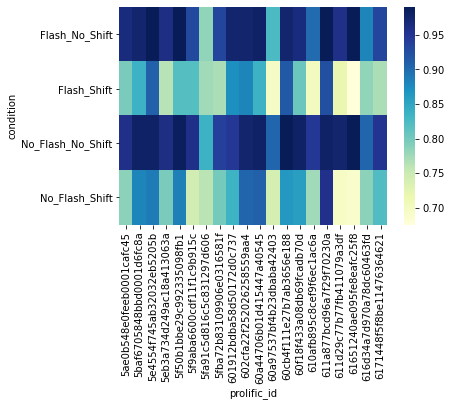

In [8]:
trial_id_condition = trial_data.groupby(['prolific_id', 'condition']).describe()
trial_performance_data = trial_id_condition['success']
trial_performance = trial_performance_data['mean']
trial_performance = trial_performance.reset_index()
trial_performance = trial_performance.pivot("condition", "prolific_id", "mean")

sns.heatmap(trial_performance, cmap="YlGnBu");

Performance differs by condition - with shift, performance is worse than without shift. 

#### What causes the higher error rate? More missed responses or more delayed responses?

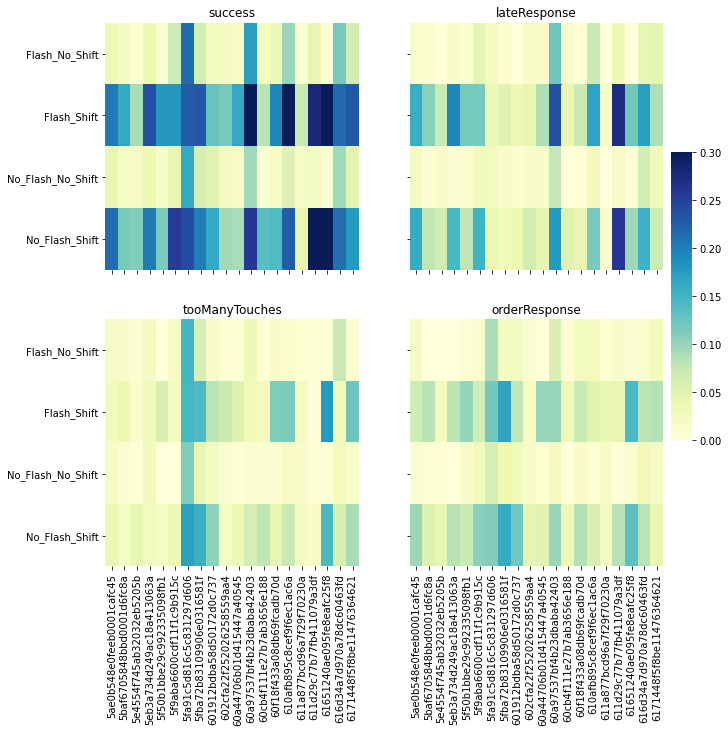

In [9]:
# grid plot by error type
error_type_fig, error_type_axs = plt.subplots(2,2, figsize = (10,10), sharex = True, sharey = True)
cbar_ax = error_type_fig.add_axes([.91, .3, .03, .4])

def show_error_heatmap(grouped_data, error_type, axs, cbar_ax):
    errors = grouped_data[error_type]['mean'].reset_index()
    if error_type == 'orderResponse' or error_type == 'success':
        errors['mean'] = 1 - errors['mean']
    errors = errors.pivot("condition", "prolific_id", "mean")
    
    sns.heatmap(errors, cmap="YlGnBu", 
                ax = axs, 
                vmin = 0, vmax = 0.3,
                cbar = None if not cbar_ax else cbar_ax,
                cbar_ax = cbar_ax)
    axs.set_title(error_type)
    axs.set_xlabel('')
    axs.set_ylabel('')
    
    
show_error_heatmap(trial_id_condition, 'success', error_type_axs[0,0], None)
show_error_heatmap(trial_id_condition, 'lateResponse', error_type_axs[0,1], None)
show_error_heatmap(trial_id_condition, 'tooManyTouches', error_type_axs[1,0], None)
show_error_heatmap(trial_id_condition, 'orderResponse', error_type_axs[1,1], cbar_ax)

We see an increase in all error types after a flash. This is not ideal, because it means that the responses were more likely to be interrupted do to a spatial error, rather than just a timeout. Any following experiment should counteract this effect by increasing the range in which an error is tolerated. 

### Screen Parameters

#### Extract device type from user info

In [10]:
# filter system information
all_user_info = np.unique(question_data['userInfo'].dropna())
get_device = lambda user_info: user_info.split('(')[1].split(')')[0].split('; ')[2]
all_devices = [get_device(system) for system in all_user_info]
all_devices = np.unique(all_devices)

In [11]:
# add device name to trial data
trial_data['device'] = [get_device(user_info) for user_info in trial_data['userInfo']]

- ANE-AL00: Huawei P20 Lite, Screen: IPS LCD - capacitive multitouch - no phases
- ANE-LX1: Huawei P20 Lite Dual Sim, Screen: LTPS IPS LCD capacitive multitouch - no phases
- DRA-LX5: Huawei Y5 Lite, Screen: LCD, capacitive multitouch - no phases
- ELE-L29: Huawei P30, Screen: OLED, capacitive multitouch - no phases
- LDN-L01: Huawei Y7, Screen: IPS LCD, capacitive multitouch - no phases
- LG-M700: LG Q6, Screen: IPS LCD, capacitive multitouch - phase
- LM-G710: LG 7Q ThinQ, Screen:  IPS LCD, capacitive multitouch - phases
- M2002J9G: XIAOMI MI 10 LITE, Screen: AMOLED, capacitive multitouch - no phases
- M2101K7BG: Xiaomi Redmi Note 10S, Screen: Super AMOLED, capacitive multitouch - no phases
- Redmi Note 8 Pro: Screen: IPS LCD, capacitive - Phases
- Redmi Note 9 Pro: Screen: IPS LCD, capacitive - Phases
- SAMSUNG SM-A225F: Samsung Galaxy A22, Screen: Super AMOLED, capacitive multitouch - mixed phases
- SAMSUNG SM-A325F: Samsung Galaxy A32, Screen: Super AMOLED 90 Hz, capacitive multitouch - phases
- SM-A307FN: Samsung Galaxy A30s, Screen: Super AMOLED, capacitive multitouch - no phases
- SM-A515F: Samsung Galaxy A51, Screen: Super AMOLED, capacitive multitouch - mixed phases, adaptive frequence
- SM-A528B: Galaxy A52s 5G, Screen: Super AMOLED, capacitive multitouch - phase/ no phase in different session
- SM-G532F: Samsung Galaxy Grand Prime Plus, Screen: PLS IPS, capacitive multi-touch, - no phases
- SM-G950F: SAMSUNG GALAXY S8, Screen: Super AMOLED, capacitive multi-touch - phases
- SM-T116: Samsung Galaxy Tab 3 Lite, Screen: TFT LCD, capacitive multi-touch - no phases
- SM-T585: Samsung Galaxy Tab A, Screen: LPS LCD, capacitive multi-touch - no phases
- SNE-LX1: Huawei Mate 20, Screen: TFT/LPS? LCD, capacitive multi-touch - phases
- STK-LX3: Huawei Y9 Prime, Screen: IPS LCD, capacitive multi-touch - phases
- U693CL: UMX U693Cl, Screen: ?, 
- rv:97.0: Firefox - no phases

#### Create a custom color scheme for devices

In [12]:
device_colors = {
    'ANE-AL00': '#ED9E97', # huawei (red)
    'ANE-LX1': '#E77E74', # huawei (red)
    'DRA-LX5': '#E15D51', # huawei (red)
    'ELE-L29': '#9D251B', # huawei (red)
    'LDN-L01': '#7A1D15' ,# huawei (red)
    'LG-M700': '#F5A651', # lg (orange)
    'LM-G710': '#F28818', # lg (orange)
    'M2002J9G': '#FFF870', # xiaomi (yellow)
    'M2101K7BG': '#F5E900', # xiaomi (yellow)
    'Redmi Note 8 Pro': '#CCC200', # xiaomi (yellow)
    'Redmi Note 9 Pro': '#A39B00', # xiaomo (yello)
    'SAMSUNG SM-A225F': '#DDEAD7', # samsung (green)
    'SAMSUNG SM-A325F': '#C7DBBD', # samsung (green)
    'SM-A307FN': '#B1CCA3', # samsung (green)
    'SM-A515F': '#9ABE89', # samsung (green)
    'SM-A528B': '#83AF6E', # samsung (green)
    'SM-G532F': '#6D9E57', # samsung (green)
    'SM-G950F': '#5B8448', # samsung (green)
    'SM-T116': '#49693A', # samsung (green)
    'SM-T585': '#374F2B', # samsung (green)
    'STK-LX3': '#DC3C2E', # huawei (red)
    'SNE-LX1': '#C02E21', # huawei (red)
    'U693CL': '#463F0C', # UMX - Assurance Wireless
    'rv:97.0': '#1D1A05' # firefox/unknown
}

#### Create a mapping between jatos worker and device

In [13]:
successful_trials_path = data_path + 'all_successful_trials.pkl'
jatos_device_mapping = {}

for worker in np.unique(trial_data.subject):
    jatos_device_mapping[worker] = np.unique(trial_data[trial_data.subject == worker].device)[0]
    
trial_data['device'] = trial_data.subject.replace(jatos_device_mapping)
trial_data_successful = trial_data[trial_data.success == 1]
trial_data_successful.reset_index(inplace=True, drop=True)

trial_data_successful.to_pickle(successful_trials_path)

In [ ]:
worker_from_questions = np.unique(question_data.subject)

#### Size

In [ ]:
screen_data = trial_data[trial_data.screenInLandscape == 1]

In [ ]:
device_group = screen_data.groupby('device').describe()
width = device_group['windowWidth']['max']
height = device_group['windowHeight']['max']
fig, axs = plt.subplots(1,1)
axs.set_xlim(0,1400)
axs.set_ylim(0,850)
sns.scatterplot(x = width.values, y = height.values, hue = width.index, palette = device_colors)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');

In [ ]:
trial_data.head()

#### Refresh Rate

In [ ]:
# compute differences between screen refresh timestamps
animation_timestamps_diff = np.array([np.diff(trial_data.animation_timestamps[x]) 
                             for x in trial_data.index], copy = False, dtype = object)

trial_data.loc[trial_data.index, 'animation_timestamps_diff'] = animation_timestamps_diff

In [ ]:
# plot mean refresh values per device
# show variation around mean
devices = np.unique(trial_data.device) 

fig_device_animation_frames, axs_device_animation_frames = plt.subplots(int(np.ceil(len(devices)/4)), 4, 
                                                                          figsize = (20,20), 
                                                                          sharex = True)

means = []
medians = []
stds = []

for d, ax in zip(devices, axs_device_animation_frames.flatten()):
    
    animation_frame_data = np.concatenate(
        trial_data[trial_data.device == d]['animation_timestamps_diff'].values
    ).flatten()
    
    mean_frame = np.mean(animation_frame_data)
    median_frame = np.median(animation_frame_data)
    std_frame = np.std(animation_frame_data)
    
    means.append(mean_frame)
    medians.append(median_frame)
    stds.append(std_frame)
    
    ax.hist(animation_frame_data[animation_frame_data <= 2*median_frame], bins = 35, color = device_colors[d])
    ax.set_title(f"dev: {d}, med: {round(median_frame, 2)}, sd: {round(std_frame,2)}")
    

The mean value is quite well centered on one single bin, the median is at ~16.6666 ms for most devices, which would correspond to a 60Hz frame rate.

#### Screen refresh rate over trial

In [ ]:
refresh_diff = pd.DataFrame(trial_data.animation_timestamps_diff.values.tolist(), index = trial_data.index)
refresh_diff.dropna(axis = 0, how = 'all', inplace = True)
refresh_diff['device'] = trial_data.device
refresh_diff['success'] = trial_data.success

In [ ]:
success_refresh = refresh_diff[refresh_diff.success == 1].dropna(axis = 1)
success_refresh.drop('success', inplace = True, axis = 1)
mean_rates = success_refresh.groupby('device').mean()
std_rates = success_refresh.groupby('device').std()

trial_rate_fig, axs_trial_rate = plt.subplots(int(np.ceil(len(devices)/4)), 4, 
                                              figsize = (20,20),
                                              sharex = True, sharey = True)

for d, ax in zip(devices, axs_trial_rate.flatten()):
    ax.plot(std_rates.columns, mean_rates.loc[d])
    ax.fill_between(std_rates.columns, mean_rates.loc[d] + std_rates.loc[d],
                   mean_rates.loc[d] - std_rates.loc[d], alpha = 0.5) 

    ax.set_title(d)

#### distance between unser interaction and next screen repaint

In [ ]:
fig_device_frame_delay, axs_device_frame_delay = plt.subplots(int(np.ceil((len(devices)/4))), 4, 
                                                                          figsize = (20,20), sharey = True)

means = []
medians = []
stds = []

for d, ax in zip(devices, axs_device_frame_delay.flatten()):
    
    animation_frame_data = np.concatenate(
        trial_data[trial_data.device == d]['animation_timestamps_to_touchOnTime'].values
    ).flatten()
    
    mean_frame = np.mean(animation_frame_data)
    median_frame = np.median(animation_frame_data)
    std_frame = np.std(animation_frame_data)
    
    means.append(mean_frame)
    medians.append(median_frame)
    stds.append(std_frame)
    
    # an_frame_clean = animation_frame_data[animation_frame_data <= median_fram + 2 * std_frame]
    
    ax.hist(animation_frame_data, bins = int(round((max(animation_frame_data) - min(animation_frame_data))/1)), 
            color = device_colors[d])
    ax.set_xlim(0,18)
    ax.set_title(f"{d}")

    
plt.tight_layout()

We observe two different patterns for screen repaint timing after interaction - either a uniform distribution of timestamps between 0 - 16 ms after the interaction, or an aligned rythmic repaint with a period of 6 - 8 ms.

The rythmic repaint is somewhat inexplicable to me and could have different reasons:

1. the browser limits how many commands browser-based js can perform per second
2. the timing is inaccurate for some phones (but then I would expect messier data)
3. the browser handles repaints like nested timeout calls and adds a 4ms delay (https://developer.mozilla.org/en-US/docs/Web/API/setTimeout#reasons_for_delays_longer_than_specified)

#### Suggested reason:

Talking to Pablo Prietz, he made the following suggestion: 
Some screens get the response from the touch screen on an event-based system - if there was a touch interaction, the information and the time stamp is sent to the phone. This would result in a non-rythmical alignment between touch interaction and screen refresh. However, some other phones might "ask" the screen in regular intervals for new events. 
This results in peaks in the distribution - like here, depending on how the peaks are phased with respect to the screen refresh. Regular touch refresh times vary between 120-300Hz 

#### accuracy of event timing

In [ ]:
event_diff = trial_data.scheduled_eventOnTime - trial_data.eventOnTime
print(f'median: {np.median(event_diff)}')
print(f'mean: {np.mean(event_diff)}')
print(f'std: {np.std(event_diff)}')

clean_diff = event_diff[event_diff < np.median(event_diff) + 3 * np.std(event_diff)]
clean_diff = clean_diff[clean_diff > np.median(event_diff) - 3 * np.std(event_diff)]

In [ ]:
event_timing_fig, event_timing_axs = plt.subplots(1,1)
event_timing_axs.hist(clean_diff, bins = int(round(max(clean_diff) - min(clean_diff))))
event_timing_axs.set_xlabel('delay relative to scheduled appearance')
event_timing_axs.set_ylabel('count');

#### event accuracy after interaction

In [ ]:
fig_device_event_accuracy, axs_device_event_accuracy = plt.subplots(int(np.ceil((len(devices)/4))), 4, 
                                                                          figsize = (20,20), sharey = True)

for d, ax in zip(devices, axs_device_event_accuracy.flatten()):
    
    device_data = trial_data[trial_data.device == d]
    ax.scatter(device_data.interaction_to_change_distance, 
               device_data.scheduled_eventOnTime - device_data.eventOnTime,
              color = device_colors[d])
    ax.set_xlim([-700, 20])
    ax.set_ylim([-70, 5])
    ax.set_title(d);

Most devices show accurate timing of user - screen repaint interaction. The SM-T116 (Samsung Tablet) shows the most deviations.

#### calibration parameters

In [ ]:
# Calibration tests
valid_calibs = [helper.calibration_valid(calibration_params.loc[idx]) for idx in calibration_params.index]
valid_calib_params = calibration_params[valid_calibs]

valid_workers = [worker in worker_from_questions for worker in valid_calib_params.subject]
valid_calib_params = valid_calib_params[valid_workers] 

last_calib_in_session = [valid_calib_params[valid_calib_params.session_id == s].index[-1] for s in np.unique(valid_calib_params.session_id)]
valid_calib_params = valid_calib_params.loc[last_calib_in_session, :]

valid_calib_params['device'] = [jatos_device_mapping[worker] for worker in valid_calib_params.subject]

fig_cali, axs_cali = plt.subplots(2,3, figsize = (20, 10))

# px2mm
sns.scatterplot(data = valid_calib_params, 
                 y = 'px2mm', 
                 x = 'prolific_id', 
                 hue = 'device', 
                 ax = axs_cali[0,0], 
                 legend = True,
                 palette = device_colors);
axs_cali[0,0].set_xticklabels([]);
axs_cali[0,0].legend(bbox_to_anchor=(-0.2, 1))


# view_dist_mm
sns.scatterplot(data = valid_calib_params, 
                y = 'view_dist_mm', 
                x = 'prolific_id', 
                hue = 'device', 
                ax = axs_cali[0,1], 
                legend = False,
                palette = device_colors);
axs_cali[0,1].set_xticklabels([]);

# item_width_deg
sns.scatterplot(data = valid_calib_params, 
                y = 'item_width_deg', 
                x = 'prolific_id', 
                hue = 'device', 
                ax = axs_cali[0,2], 
                legend = False,
                palette = device_colors);
axs_cali[0,2].set_xticklabels([]);

# pix2deg
sns.scatterplot(data = valid_calib_params, 
                y = 'px2deg', 
                x = 'prolific_id', 
                hue = 'device', 
                ax = axs_cali[1,0], 
                legend = False,
                palette = device_colors);
axs_cali[1,0].set_xticklabels([]);

# win_width_deg
sns.scatterplot(data = valid_calib_params, 
                y = 'win_width_deg', 
                x = 'prolific_id', 
                hue = 'device', 
                ax = axs_cali[1,1], 
                legend = False, 
                palette = device_colors);
axs_cali[1,1].set_xticklabels([]);

screen_width_session = screen_data.groupby(['session_id', 'device']).describe()['windowWidth']['max'].reset_index()
calibrated_width_session = valid_calib_params.groupby(['session_id', 'device']).describe()['win_width_deg']['max'].reset_index()

# win_width_deg
sns.scatterplot(y = calibrated_width_session['max'], 
                x = screen_width_session['max'],
                hue = screen_width_session['device'],
                ax = axs_cali[1,2], 
                legend = False, 
                palette = device_colors
               );



#### Compare variability in item width with variability in credit card measure vs. view distance

In [ ]:
calibration_summary = valid_calib_params.groupby('prolific_id').describe()

fig_variation, axs_variation = plt.subplots(1,2, figsize = (15,5))

sns.scatterplot(data = calibration_summary, 
                x = calibration_summary.px2mm['std'], 
                y = calibration_summary.item_width_deg['std'], 
                ax = axs_variation[0],
                hue = calibration_summary.index,
               palette = 'icefire')
axs_variation[0].legend(bbox_to_anchor=(-0.2, 1))
axs_variation[0].set_xlabel('std in mm/px')
axs_variation[0].set_ylabel('std in item width in deg')
axs_variation[0].set_title('Credit Card Test')

sns.scatterplot(data = calibration_summary, 
                x = calibration_summary.view_dist_mm['std'], 
                y = calibration_summary.item_width_deg['std'], 
                ax = axs_variation[1],
                hue = calibration_summary.index,
               palette = 'icefire',
               legend = False)

axs_variation[1].set_xlabel('std in viewing distance in mm')
axs_variation[1].set_ylabel('std in item width in deg')
axs_variation[1].set_title('Blind Spot Test');

## Demographic Data

In [ ]:
prolific_metadata = pd.read_csv(metadata_path + 'prolific_meta_session_4.csv')
prolific_metadata = prolific_metadata[prolific_metadata.participant_id !=  '5f9f4660d0edb75784c68223']

#### age

In [ ]:
age_participants = prolific_metadata.age
plt.hist(age_participants);
print(f'Median age: {np.median(age_participants)}')
print(f'Max age: {max(age_participants)}')
print(f'Min age: {min(age_participants)}')
print(f'Std age: {np.std(age_participants)}')

#### gender

In [ ]:
plt.hist(prolific_metadata.Sex);
print(f"n male: {len(prolific_metadata[prolific_metadata.Sex == 'Male'])}")
print(f"n female: {len(prolific_metadata[prolific_metadata.Sex == 'Female'])}")

print(f"Percentage female: {round(len(prolific_metadata[prolific_metadata.Sex == 'Female'])/len(prolific_metadata),2)*100} %")

#### handedness

In [ ]:
question_session_4 = question_data[question_data.session_number == 4.]
handedness = question_session_4[question_session_4.test_part == 'outro_hand'].reset_index(drop = True)
handedness.dropna(axis = 1, inplace = True)

print(f"n right-handed: {len(handedness[handedness.survey_response == 'right'])}")
print(f"n left_handed: {len(handedness[handedness.survey_response == 'left'])}")

plt.hist(handedness.survey_response);

#### location

In [ ]:
plt.hist(prolific_metadata['Current Country of Residence'], bins = 50)
plt.xticks(rotation = 90);

## Data Preprocessing

- Extract successful data points
- check outliers -> how many are there for each participant, color-code them
- Mean center x and y coordinates

#### Outlier detection
Plot the distance between the dot touch response and the dot location.

In [ ]:
subjects = np.unique(trial_data_successful.prolific_id)
sessions = np.unique(trial_data_successful.session_number)

position_fig, position_axs = plt.subplots(len(subjects), len(sessions), 
                                          figsize = (20, 50), sharex = True, sharey = True)

for row_id, subject in enumerate(subjects):
    subject_data = trial_data_successful[trial_data_successful.prolific_id == subject]
    
    for col_id, session in enumerate(sessions):
        session_data = subject_data[subject_data.session_number == session]
        
        x_vals = np.concatenate(session_data['touchX'].values).flatten()
        y_vals = np.concatenate(session_data['touchY'].values).flatten()
        position_axs[row_id, col_id].scatter(x_vals, y_vals)
    


#### Touch responses relative to true dot position
- find position of dot during response
- find position of dot in px on screen
- compute difference between dot position and touch response

In [ ]:
relative_position_fig, relative_position_axs = plt.subplots(
    len(subjects), 
    len(sessions), 
    figsize = (20, 50),
    sharex = True, sharey = True)

for row_id, subject in enumerate(subjects):
    subject_data = trial_data_successful[trial_data_successful.prolific_id == subject]
    
    for col_id, session in enumerate(sessions):
        session_data = subject_data[subject_data.session_number == session]
        
        x_vals = np.concatenate(session_data['pos_x_touch_x_dist'].values).flatten()
        y_vals = np.concatenate(session_data['pos_y_touch_y_dist'].values).flatten()
        relative_position_axs[row_id, col_id].scatter(x_vals, y_vals)
        relative_position_axs[row_id, col_id].set_title(np.unique(session_data.device)[0])
    

### Normalization of the error 
We tried to adjust the size of the points in pixel to what they would be in degree visual angle. So the size and deviation in pixel above might give an inaccurate idea of the deviation relative to the actual size of the dots. 
To correct for this, we normalize the touch responses to dva. The response target had a diameter of 1 dva. So by dividing the distances in pixel by the numbers of pixel per degree, we get the distance in degrees, and also as a fraction of the size of the target itself.

### Include marking outliers
Outliers will be color-coded as all points that were at least 3* the standart deviation away from the center of the dot.

In [ ]:
normalized_dva_position_fig, normalized_dva_position_axs = plt.subplots(
    len(subjects), 
    len(sessions), 
    figsize = (10, 50),
    sharex = True, sharey = True)

for row_id, subject in enumerate(subjects):
    subject_data = trial_data_successful[trial_data_successful.prolific_id == subject]
    normalized_dva_position_axs[row_id, 0].set_ylabel(subject[:5])
    
    for col_id, session in enumerate(sessions):
        session_data = subject_data[subject_data.session_number == session]
        
        x_vals = np.concatenate((session_data['pos_x_touch_x_dist_dva']).values).flatten()
        y_vals = np.concatenate((session_data['pos_y_touch_y_dist_dva']).values).flatten()
        
        x_limit = abs(np.mean(x_vals)) + 3 * np.std(x_vals)
        y_limit = abs(np.mean(y_vals)) + 3 * np.std(y_vals)
        
        normalized_dva_position_axs[row_id, col_id].scatter(x_vals, y_vals)
        normalized_dva_position_axs[row_id, col_id].scatter(x_vals[abs(x_vals) >= x_limit], y_vals[abs(x_vals) >= x_limit], color = 'red')
        normalized_dva_position_axs[row_id, col_id].scatter(x_vals[abs(y_vals) >= y_limit], y_vals[abs(y_vals) >= y_limit], color = 'red')
        normalized_dva_position_axs[row_id, col_id].set_title(np.unique(session_data.device)[0])
    

It seems like the deviation is more uniformly distributed within sessions/users when expressed in dva compared to pixel. One reason for that could be that the allowed range is set in dva rather than in pixel.

Another could be that the aiming precision is dependent on the visual information rather than on size relative to finger.

### Normalize all positions into dva rather than pixel (relative to screen center).

In [ ]:
# done in preprocessing

### Deviation by dot position in grid (rather than by session)

In [ ]:
normalized_dva_position_sequence_fig, normalized_dva_position_sequence_axs = plt.subplots(
    len(subjects), 
    6, 
    figsize = (15, 50),
    sharex = True, sharey = True)

for row_id, subject in enumerate(subjects):
    subject_data = trial_data_successful[trial_data_successful.prolific_id == subject]
    normalized_dva_position_sequence_axs[row_id, 0].set_ylabel(subject[:5])
    
    for position in range(6):
        x_vals = np.array([subject_data['pos_x_touch_x_dist_dva'][x][position] for x in subject_data.index])
        y_vals = np.array([subject_data['pos_y_touch_y_dist_dva'][x][position] for x in subject_data.index])
    
        x_limit = abs(np.mean(x_vals)) + 3 * np.std(x_vals)
        y_limit = abs(np.mean(y_vals)) + 3 * np.std(y_vals)
        
        normalized_dva_position_sequence_axs[row_id, position].scatter(x_vals, y_vals)
        normalized_dva_position_sequence_axs[row_id, position].scatter(x_vals[abs(x_vals) >= x_limit], y_vals[abs(x_vals) >= x_limit], color = 'red')
        normalized_dva_position_sequence_axs[row_id, position].scatter(x_vals[abs(y_vals) >= y_limit], y_vals[abs(y_vals) >= y_limit], color = 'red')
        normalized_dva_position_sequence_axs[row_id, position].scatter(np.mean(x_vals), np.mean(y_vals), color = 'limegreen')
        

The first dot is touched with higher accuracy than the following dots. By eye, it is not possible to see a clear difference between the subsequent dots.

### Show the development of accuracy over dots

##### Get the mean vector length for each dot averaged over participants
##### Plot the mean over sessions and the mean of participant means

In [ ]:
touch_accuracy_by_participant = pd.DataFrame()

for s in subjects:
    s_data = trial_data_successful[trial_data_successful.prolific_id == s]
    s_accuracy_summary = np.mean(s_data.vector_touch_distance_dva)
    s_accuracy_df = pd.DataFrame(s_accuracy_summary)
    s_accuracy_df['touch_id'] = np.arange(0,6)
    s_accuracy_df['subject'] = s
    
    touch_accuracy_by_participant = pd.concat([touch_accuracy_by_participant, s_accuracy_df], ignore_index = True)

In [ ]:
accuracy_fig, accuracy_axs = plt.subplots(1,1)
sns.lineplot(data=touch_accuracy_by_participant, x="touch_id", y=0, 
             hue="subject", palette='Greys', alpha = 0.5, 
             legend = False, ax = accuracy_axs)

sns.lineplot(data=touch_accuracy_by_participant, x="touch_id", y=0, 
             color='Green', linewidth = 3, legend = False, ax = accuracy_axs)

accuracy_axs.set_title('Accuracy of responses over dots')
accuracy_axs.set_xlabel('Trial ID (1-4)')
accuracy_axs.set_ylabel('Accuracy in degree');

In [ ]:
# find the outlier subject
print(np.unique(touch_accuracy_by_participant[touch_accuracy_by_participant[0]>1]['subject']))

One subject makes visibly larger errors than the other subjects. This subject is subject has the id 61651240ae095fe8eafc25f8. They reported in the questionnaire to take ADHD medication. From visual inspection, I couldn't find other differences to other subjects - the pixel to degree transformation does not look unusual, either.

The data does not look suspicious in the other plots, where I was looking at the deviation around the center. That's weird and I'll explore this further.

### Check the direction of deviation for each subject

### Build a long format dataset.
Plotting the data from individual data points is easier if we have them in a long format, where one column indicates the position of the point in the array, and another column contains the value we are looking for.

In [ ]:
# Create Figure
touch_placements_frequency_fig = plt.figure(figsize = [6*3,20*3]) 
touch_placement_frequency_axs = []

# Make axis for each subplot
for s in range(len(subjects)):
    for dot_id in range(6):
        ax = plt.subplot(len(subjects), 6, (s*6) + dot_id+1, projection = 'polar')
        touch_placement_frequency_axs.append(ax)

# function to show responses on radial axis
def show_radial_histogram(angles, ax, N=36, normalize = False):
    theta = np.linspace(0, 2 * np.pi, N, endpoint=False) # location on the circle
    radii = np.histogram(angles, bins = N)[0] # line radius (height of the bar - this will be the height of our histogram)
    if normalize:
        radii = radii/sum(radii)
    width = (2*np.pi)/N # like binwidth
    colors = plt.cm.viridis(radii/max(radii))

    ax.bar(theta, radii, width = width, bottom=0.0, color=colors, alpha=0.5)
    # scale everything to the same axis
    if not normalize:
        ax.set_ylim([0,130])
    else:
        ax.set_ylim([0,0.15])

# make the circular plot for each subject and dot
for s, s_id in enumerate(subjects):
    s_data = trial_data_long_format[trial_data_long_format.prolific_id == s_id]
    touch_placement_frequency_axs[s*6].set_ylabel(s_id[:5], position = (1,0.5))
    for dot_id in range(6):
        angles = s_data[s_data.choiceOrder == dot_id]['touch_deviation_angle']
        show_radial_histogram(angles, touch_placement_frequency_axs[s*6 + dot_id], normalize = True)

        
plt.suptitle('Frequency of touch responses by direction and dot ID', position = (0.5, 1.001))
plt.tight_layout()

### Check vector length of deviation for each subject

todo: maybe color by phone?

In [ ]:
trial_data_long_format['touch_deviation_rad'] = trial_data_long_format.touch_deviation_angle.apply(math.radians)
trial_data_long_format.to_csv(successful_trials_long_path, index = False)

In [ ]:
# Create Figure
touch_placements_distance_fig = plt.figure(figsize = [6*3,20*3]) 
touch_placement_distance_axs = []

# Make axis for each subplot
for s in range(len(subjects)):
    for dot_id in range(6):
        ax = plt.subplot(len(subjects), 6, (s*6) + dot_id+1, projection = 'polar')
        touch_placement_distance_axs.append(ax)

for row_id, subject in enumerate(subjects):
    subject_data = trial_data_long_format[trial_data_long_format.prolific_id == subject]
    touch_placement_distance_axs[row_id*6].set_ylabel(subject[:5])
    
    for position in range(6):
        pos_data = subject_data[subject_data.choiceOrder == position]
        touch_placement_distance_axs[row_id*6 + position].bar(
            pos_data.touch_deviation_rad, 
            pos_data.vector_touch_distance_dva, 
            0.02, 
            alpha = 0.5)
        
        touch_placement_distance_axs[row_id*6 + position].set_ylim([0,2.5])
        
        

The person with the large deviation made very consistent responses to one side of the dot, and more errors close two 2 dva. Overall, the pattern from that person looks a bit like a linear offset of the responses upwards.

In [ ]:
error_angle_fig, error_angle_axs = plt.subplots(5,4, sharex = True, sharey = True, figsize = (20,15))

for s, axs in zip(subjects, error_angle_axs.flatten()):
    
    df = trial_data_long_format[trial_data_long_format.prolific_id == s]
    axs.set_title(s[:5])
    axs.scatter(df.touch_deviation_angle, df.vector_touch_distance_dva, alpha = 0.2)



In [ ]:
# TODO: Average the touch responses across people

# ANALYSIS RESPONSE INHIBITION

In this part of the analysis, I want to answer the question "are manual responses inhibited after a change in the environment?"